In [1]:
import numpy as np
import copy
import pickle
import glob

from scipy import ndimage
from BaselineRemoval import BaselineRemoval
import matplotlib.pyplot as plt
import os
from scipy import interpolate
from scipy import signal
from scipy.fft import fft, ifft, fftfreq, dct
from sklearn.decomposition import PCA
import timeit
from os import path

from signal_processing import smoothing, splitting

plt.rcParams['figure.figsize'] = (20.0, 10.0)
# plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['figure.dpi'] = 500
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

Mogelijke verbeteringen:
 - maak de covariance afhankelijke van de noise 
 - draai de spectrum zodanig dat de globale sloop de x-as is. Zodat het min-max algorithme beter werkt. DONE
 - de smoothing die applied wordt door de covariantie moet afgesteld worden per sample

Problemen:
 - initializatie maakt uit voor de kalman smoother (hoeveel noise er is vs raman)
 - aantal iteratie maakt uit voor de kalman smoother (hoeveel noise er is vs raman)
 - de bounderies hebben geen invloed op de kalman smoother buiten alles binnen de bounderies houden.
   Tenzij smoothing ook aanstaat.
   
   
excitation laser maakt uit hoe de raman laser eruit ziet. Hoger (rood) betekend lower raman signal en een breder signal

date: 2-9-2022

 - stabilise the logic part with neighbourhood information
 - where the logic part is true make the line segments bigger (does not work)
 - find something to deterime the smoothness of the poly fit (no bumbs) DONE


# important facts

#### dirac delta gives an cosine in the fourier space where the period is equal to 2N/(n+0.5)
#### FWHM to freq index is: k = 2 * (w[-1] - w[0]) / (3 * FWHM)
#### gaussian is gaussian/2 in cosine transform space


### Ideas:

- Wavelet transform (for NN to big as an input)

### Errors:

 - smooth_grad fix the try except clause such that and the beginning and end of the spectrum it also works
 - using fourier transform it seems that gibbs phenomena is a problem (spectral leakage). Also a dirac function becomes a cosine/sine wave in the fourier space. After a LPB this looks like gibbs phenomena aswell, closely related
 - in the raman spectra nan values are returned for the UnivariateSpline method when approimating the imaginary part of the fft


In [6]:
file_location = "../data/Raman_Mouse/preprocessed/"
# file_location = "../data/Green_excitation/corrected_4_wavenumbers/"

filenames = glob.glob(file_location+'/[!Wavenumbers]*.npy')
with open(f"{'/'.join(file_location.split('/')[:-2])}/Sample_labels.pickle", 'rb') as f:
    labels = pickle.load(f)
labels = {l.split(".")[0]: val for l, val in labels.items()}

wavenumbers = np.load(f"{file_location}Wavenumbers.npy")
    
def unit_vector_norm(X):
    return (X.T / np.sqrt((X**2).sum(axis=1))).T
    
NORM = False
func = unit_vector_norm if NORM else lambda x:x
    
data = []
for f in filenames:
    x = np.load(f)
    data.append((func(x.reshape(-1,x.shape[-1])).reshape(x.shape),))
#     break
    
# #mouse image
# noise_amount = 1e5
# intervals = 10
# general_noise = 10e6
# poly_fit = 1e5
# precision = 12
# continue_gap = 100
# # green image
# noise_amount = 3e5
# general_noise = 5e6
# intervals = 30
# precision = 20
# poly_fit = 8e5
# continue_gap = 400

In [7]:
"""
IDEA BEZIER_curve Trough 3 points can be achieved by two bezier curves where two anchor points are calculate between L and M and M and R. 
This can be done by calculating the gradient between L and R and multiply the gradient by half the distance between L and M plus M. (same for R)
"""


def Bezier_curve(p0,p1,p2):
    x0, x1, x2 = p0[0], p1[0], p2[0]
    b, a = x0 - x1, x0 - 2*x1 + x2
    d = x1**2 - x0*x2
    def inv_B(x):
        if not a:
            return np.linspace(0,1,x.shape[-1])
        return (b + np.sqrt(d + a * x)) / a
    
    p0, p1, p2 = p0[1], p1[1], p2[1]
    p1 = 0
    def B(t):
        return (1-t)**2 * p0 + 2*(1-t)*t * p1 + t**2 * p2 
    
    return B, inv_B

def fit_gradient_line_segment(x, grad, middle, width):
    """
    LSQ seems to work better, but bezier curve is faster.
    Let the user decide
    
    """
    left, right = np.maximum(0, middle-width), np.minimum(x.shape[-1]-1, middle+width)
    middle = np.minimum(x.shape[0]-1,np.maximum(middle, 0))
    width = right-left
    if left == middle:
        middle += 1
    elif right == middle:
        middle -= 1
    
    grad_left = grad[left]
    grad_middle = grad[middle]
    grad_right = grad[right]
#     left_grad = np.linspace(grad_left, grad_middle, middle-left)
#     right_grad = np.linspace(grad_middle, grad_right, right-middle)
#     grad = np.concatenate((left_grad, right_grad))

    axis = np.arange(left, right)
    order = np.arange(3)
    kernel = axis[:, np.newaxis]**order
    p, *_ = np.linalg.lstsq(kernel, grad[left: right], rcond=None)
    grad = np.sum(kernel * p, 1)

#     p0 = np.array([left, grad_left])
#     p1 = np.array([middle, grad_middle])
#     p2 = np.array([right, grad_right])
    
#     B, inv_B = Bezier_curve(p0, p1, p2)
#     x_axis = np.arange(left, right+1)
#     grad = B(inv_B(x_axis))[:-1]
       
    value = 0
    slope = [0]
    for g in grad:
        value += g
        slope.append(value)

    slope = np.array(slope)
    index = np.argmin(x[left:right+1] - slope)
    slope -= slope[index]

    slope += x[left+index]
#     plt.plot(x_axis, slope)
    return slope, left, right+1

def init_poly_approximation(continue_gap=400, intervals=50, size=1300):
#     mu, sigma = np.linspace(0,1,11), np.linspace(0.1,0.3,1) # green
#     mu, sigma = np.linspace(0,1,11), np.linspace(0.2,0.3,3) # green
#     mu, sigma = np.linspace(-0.1,1.1,11), np.linspace(0.1,0.3,3) # green
    mu, sigma = np.linspace(0,1,10), np.linspace(0.5,0.7,1) # normal
    photo_approximation = splitting.photo_approximation(9, mu, sigma, size=size)
    def poly_approximation(x, approximation):
        step = x.shape[0]//intervals
        grad =  np.pad((approximation[2:] - approximation[:-2]) / 2, (1,1), 'edge')
        grad[0] -= grad[2] - grad[1]
        grad[-1] += grad[-2] - grad[-3]
               
        start = timeit.default_timer()
        
        lst = []
        widths = [250] # original
#         widths = [400] # green
        for j in widths:
            poly_max = np.zeros(x.shape[-1])
#             plt.plot(grad, 'k', alpha=0.5)
#             plt.plot(x, 'k', alpha=0.5)
            for i in range(-j+11, x.shape[-1]+j-10, step):
                tmp, left, right = fit_gradient_line_segment(x, grad, i, j)
                poly_max[left:right] = np.maximum(poly_max[left:right], tmp)
#             plt.show()
            lst.append(poly_max)
        poly = np.min(np.array(lst), 0)
                        

        stop = timeit.default_timer()
        print('Time inner 1: ', stop - start)  
        
#         plt.plot(x)
#         plt.plot(approximation, 'k', alpha=0.5)
# #         plt.plot(grad*10, 'k')
#         for m,l in zip(lst, widths):
#             plt.plot(m, label=l)
#         plt.plot(poly, label="poly")
#         plt.legend()
#         plt.show()    

        start = timeit.default_timer()
    
        weights = np.ones(x.shape[0])
#         plt.plot(x)
#         plt.plot(poly)
        old = -1
        poly2 = poly
        poly2[poly2 <= 0] = 1e-8
        while smoothing.MAPE(poly, poly2) - old > 1e-4:
#             plt.plot(poly)
            old = smoothing.MAPE(poly, poly2)
            poly2 = photo_approximation(poly, np.diag(weights))
            to_high = poly2 > x
            weights[to_high] += 0.5
            weights /= np.mean(weights)
            poly[to_high] *= 0.9875
            poly[poly <= 0] = 1e-8
            poly2[poly2 <= 0] = 1e-8
#             plt.plot(poly2)
#         plt.show()
    
        stop = timeit.default_timer()
        print('Time inner 2: ', stop - start)  
    
        return poly2
    return poly_approximation
poly_approximation = init_poly_approximation(size=data[0][0].shape[-1])

In [8]:
"""
log-scale fitting works better, why?

preliminary_photo_approximation1  the polynomial fit order can be determined with the MAPE (if it stops increasing)

"""



remove_noise_cube_fft = smoothing.RemoveNoiseFFTPCA(algorithm='PCA_LPF', percentage_noise=None, wavenumbers=wavenumbers, min_FWHM=3, Print=False)

def split_signal(img):
    """ 
    img consists of data and label
    
    artefact due to using previous points 
    
    """   
    x = img[0].reshape(-1, img[0].shape[-1])    
    org = copy.copy(x)
    
    raman = np.empty(x.shape)
    photo = np.empty(x.shape)
    start = timeit.default_timer()
        
    # check for cube
    if np.prod(img[0].shape) != img[0].shape[-1]:
        x = remove_noise_cube_fft(x)
        
    n = 85
    plt.plot(org[n])
    plt.plot(x[n])
    plt.show()
        
    return 
    
#     mu, sigma = np.linspace(0,1,10), np.linspace(0.1,0.3,5) # green
    mu, sigma = np.linspace(0,1,10), np.linspace(0.5,0.7,5) # normal
#     preliminary_photo_approximation = splitting.preliminary_photo_approximation(1, mu, sigma, size=x.shape[-1])
    preliminary_photo_approximation = splitting.preliminary_photo_approximation(9, mu=None, sigma=None, size=x.shape[-1])

    for pixel in range(x.shape[0]):
        pixel=85
        # poly approximation
        start = timeit.default_timer()
        target = copy.copy(x[pixel])
        weights = np.ones(x.shape[-1])
#         plt.plot(target, 'k')
        old = -1
        while smoothing.MAPE(x[pixel], target) - old > 1e-3:
            old = smoothing.MAPE(x[pixel], target)
            target[target < 0] = 1e-8
            poly = preliminary_photo_approximation(target, np.diag(weights))
            weights[poly > x[pixel]] += 1
            weights /= np.mean(weights)
            target[poly > x[pixel]] *= 0.975
#             plt.plot(poly)
#             plt.plot(weights*200)
#             plt.plot(target)
#         plt.show()
#         plt.plot(x[pixel])
#         plt.plot(poly)
#         plt.show()

        
        stop = timeit.default_timer()
        print('Time 1: ', stop - start)  

        start = timeit.default_timer()
        poly2 = poly_approximation(x[pixel], poly)
        for i in range(3):
            poly2 = poly_approximation(x[pixel], poly2)
        stop = timeit.default_timer()
        print('Time 2: ', stop - start) 
        
        plt.plot(org[pixel], label="org")
        plt.plot(poly, label="approximation")
        plt.plot(poly2, label="photo")
        plt.plot(x[pixel] - poly2, label="raman")
        plt.plot(x[pixel], label="smooth")
        plt.plot(org[pixel] - x[pixel], label="noise")
        plt.legend()
        plt.show()
        
        return
        raman2 = x[pixel] - poly2
        
        # raman approximation'
#         plt.plot(remove_noise_fft(x[pixel]-poly2))
#         plt.show()
                
        raman[pixel] = raman2
        photo[pixel] = poly2
        if not pixel % 100:
            stop = timeit.default_timer()
            print(f"progress = {100* pixel / x.shape[0]}%, 100 samples time : {stop - start}")
            start = timeit.default_timer()
        
    return raman, photo

../data/Raman_Mouse/preprocessed/Liver_map_150z25_60s_#14.npy


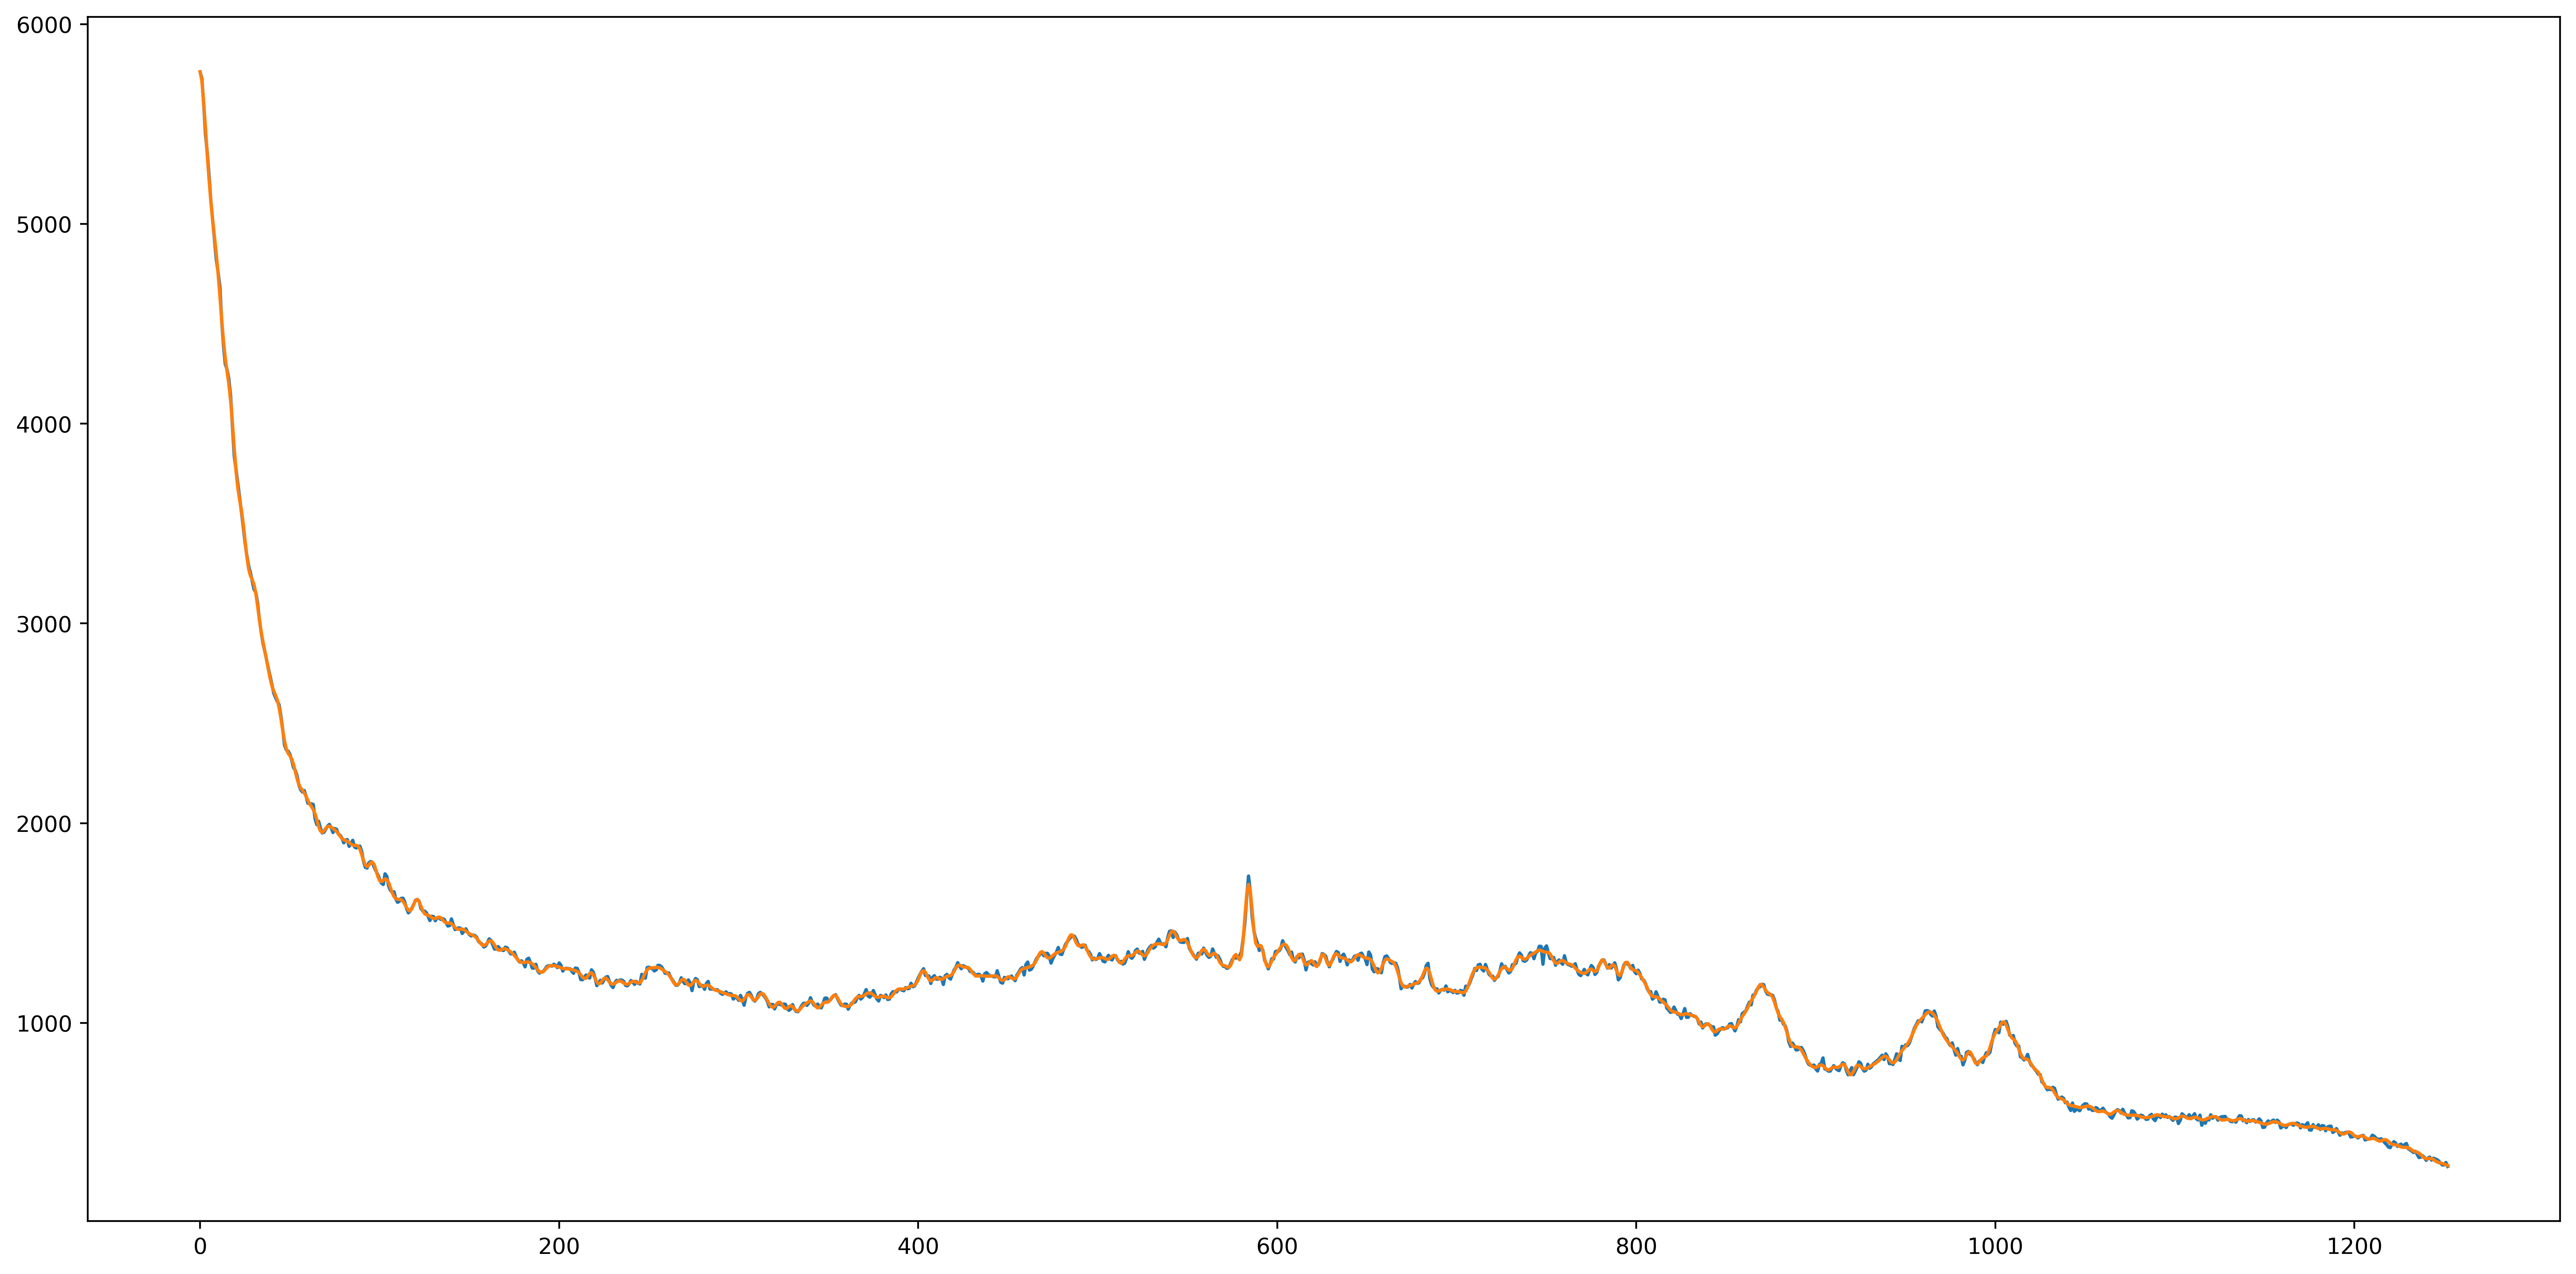

Time:  3.802135714000542
../data/Raman_Mouse/preprocessed/Muscle_map_150z25_60s_#24.npy


KeyboardInterrupt: 

In [9]:
file_location2 = f"{'/'.join(file_location.split('/')[:-2])}/approximated_curve_fit/"
os.makedirs(file_location2, exist_ok=True)

shape = data[0][0].shape

for j, (f, img) in enumerate(zip(filenames, data)):   
    start = timeit.default_timer()
#     if f != 'Liver_map_150z25_60s_#6.npy':
#         continue
#     if j < 32:
#         continue
    
    print(f)
#     if path.exists(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman.npy'):
#         print(f'file already exist {file_location2}{f.split("/")[-1].split(".")[0]}_raman')
#         continue
    split_signal(img)
#     raman, photo = split_signal(img)

    stop = timeit.default_timer()
    print('Time: ', stop - start)  
#     break

#     np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman', raman.reshape(shape))
#     np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_photoluminescence', photo.reshape(shape))
#     print(f"image: {f} is done.")
